In [ ]:
import warnings

import colorcet as cc
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy.spatial as scspatial
from desmin_reconstruction.analysis.ripley import (
    getis_franklin_L,
    getis_franklin_L_bivariate,
)
from desmin_reconstruction.analysis.z_line_detection import (
    detect_Z_lines,
    nearest_Z_line_distances,
)
from desmin_reconstruction.plotting import clustered_scatterplot, line_and_bandplot
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.preprocessing.storm import align_patch
from hdbscan import HDBSCAN
from jaxtyping import Float
from tqdm import tqdm


df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_aligned.csv")
out = df.partition_by("probe")

In [2]:
points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}
points["desmin"].shape

(59957, 3)

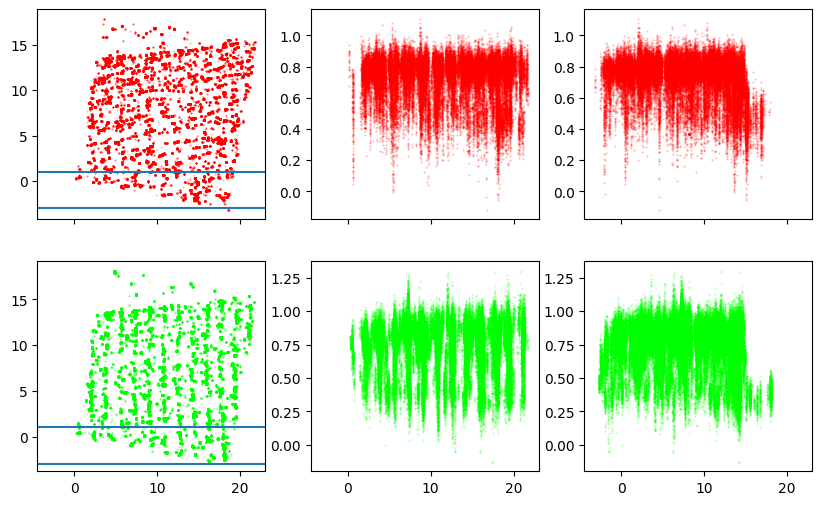

In [3]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points[protein][:, ax1],
            points[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )
for ax in axes[:, 0]:
    ax.axhline(y=1)
    ax.axhline(y=-3)

In [4]:
x0s = (2, 6, 10, 14, 18, 1, 5, 9, 13, 17, 0, 4, 8, 12, 16, 15)
y0s = (9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, -3)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [5]:
idx = 9
bbox = bboxes[idx]
sq1 = {k: filter_bounded(v, bbox) for k, v in points.items()}

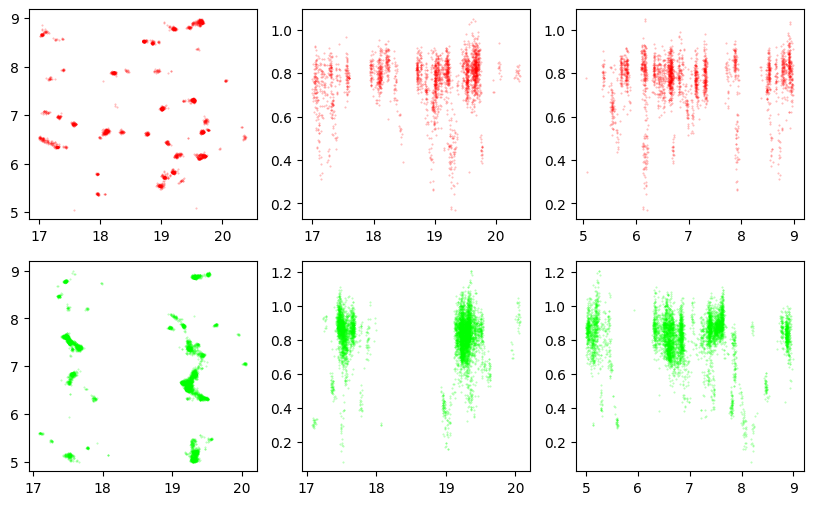

In [6]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1[protein][:, ax1],
            sq1[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )


100%|██████████| 80/80 [00:09<00:00,  8.17it/s]


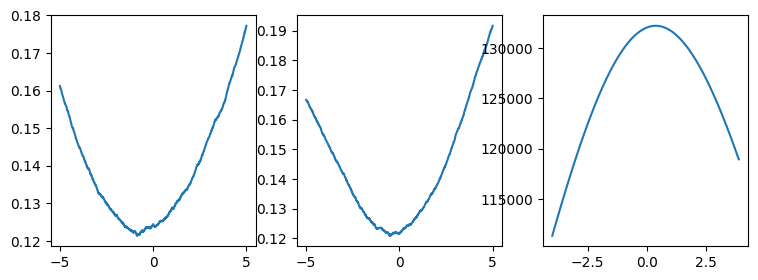

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn_sq, metrics_sq = align_patch(
        sq1,
        tilt_sweep_values=np.arange(-5, 5, 0.001),
        rotation_sweep_values=np.arange(-4, 4, 0.1),
        min_cluster_size=500,
        min_samples=10,
    )

fig, axes = plt.subplots(1, len(metrics_sq), figsize=(9, 3))
for ax, metric in zip(axes, metrics_sq):
    ax.plot(*metric)

### For a single ROI, locate the Z band

/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


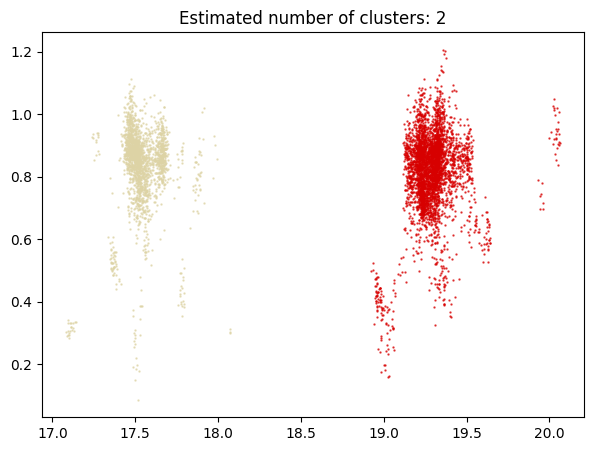

In [8]:
clusterer = HDBSCAN(min_cluster_size=500, min_samples=10)
xz = sq1["actinin"][:, np.array([0, 2])]
clusterer.fit(xz)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = clustered_scatterplot(ax, xz, clusterer.labels_)

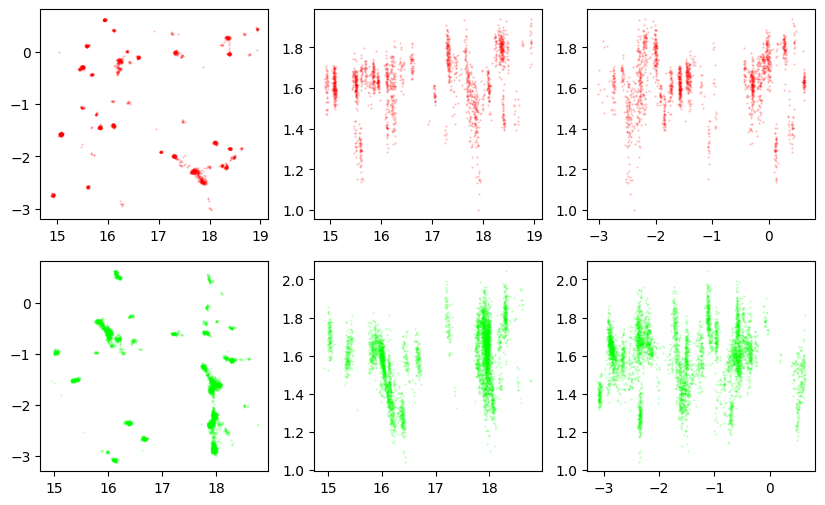

In [44]:
sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1_final[protein][:, ax1],
            sq1_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )


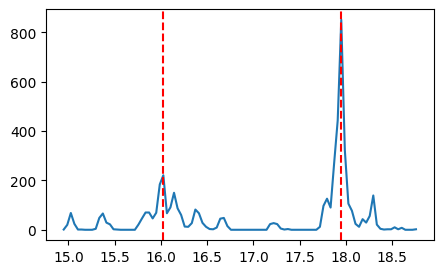

In [45]:
sarco_pos, distribution = detect_Z_lines(sq1_final["actinin"])
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(*distribution)
for pos in sarco_pos:
    ax.axvline(pos, ls="--", color="red")

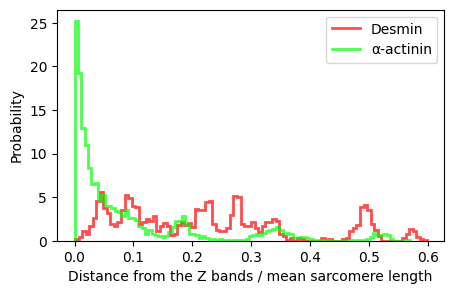

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sq_sarco_dists = {
    k: nearest_Z_line_distances(v, sarco_pos) for k, v in sq1_final.items()
}


LABEL_DICT = {"desmin": "Desmin", "actinin": "α-actinin"}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
for name, dist in sq_sarco_dists.items():
    ax.stairs(
        *np.histogram(
            dist,
            bins=100,
            density=True,
        ),
        alpha=0.7,
        linewidth=2.0,
        color=COLOR_DICT[name],
        label=LABEL_DICT[name],
    )

ax.set_xlabel("Distance from the Z bands / mean sarcomere length")
ax.set_ylabel("Probability")
# ax.set_xlim((-0.02, 0.52))
ax.legend()

In [ ]:
gf_desmin = getis_franklin_L(sq1_final["desmin"], 0.1385, [4.0, 4.0, 1.0])
gf_desmin_cross = getis_franklin_L_bivariate(
    sq1_final["desmin"], sq1_final["actinin"], 0.1385, [4.0, 4.0, 1.0]
)

(array([[146.,  19.,  13.,  39.,  24.,  12.,   5.,   2.,   0.,   3.],
        [225.,  59.,  31.,  11.,  10.,   7.,   2.,   0.,   0.,   0.],
        [166.,   8.,   7.,   3.,   5.,   0.,   0.,   0.,   0.,   0.],
        [304.,   1.,   8.,   7.,   0.,   0.,   0.,   0.,   0.,   0.],
        [254.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [185.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 31.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 74., 114.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 48.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([0.00137429, 0.06108004, 0.12078579, 0.18049154, 0.24019729,
        0.29990304, 0.35960879, 0.41931454, 0.47902029, 0.53872604,
        0.59843179]),
 array([0.        , 0.07786534, 0.15573068, 0.23359603, 0.31146137,
        0.38932671, 0.46719205, 0.5450574 , 0.62292274, 0.70078808,
    

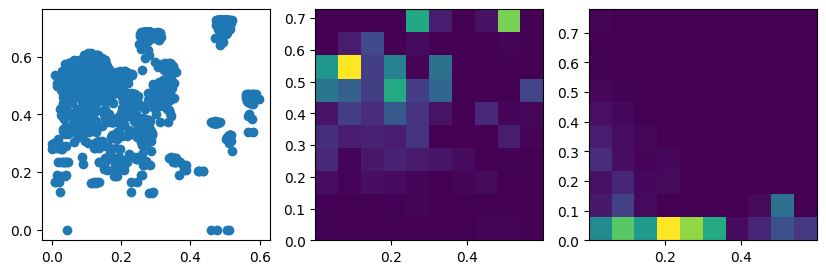

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(sq_sarco_dists["desmin"], gf_desmin)
axes[1].hist2d(sq_sarco_dists["desmin"], gf_desmin, bins=10)
axes[2].hist2d(sq_sarco_dists["desmin"], gf_desmin_cross, bins=10)


In [35]:
gf_histograms = []
bins = (np.linspace(0, 0.7, 25),) * 2

for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points.items()}
    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore")
    #     transform_fn_sq, _ = align_patch(
    #         sq1,
    #         tilt_sweep_values=np.arange(-5, 5, 0.001),
    #         rotation_sweep_values=np.arange(-4, 4, 0.1),
    #         min_cluster_size=500,
    #         min_samples=10,
    #     )
    # sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}

    gf_desmin = getis_franklin_L(sq1["desmin"], 0.1385, [4.0, 4.0, 1.0])
    gf_desmin_cross = getis_franklin_L_bivariate(
        sq1["desmin"], sq1["actinin"], 0.1385, [4.0, 4.0, 1.0]
    )
    gf_histograms.append(np.histogram2d(gf_desmin, gf_desmin_cross, bins)[0])

100%|██████████| 16/16 [00:03<00:00,  4.85it/s]


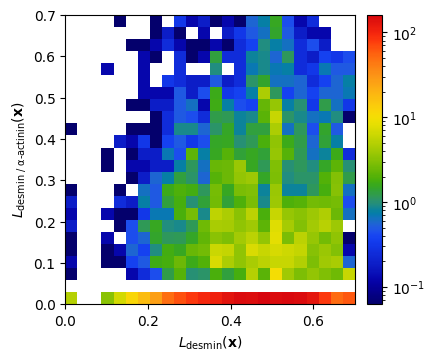

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), constrained_layout=True)
mesh = ax.pcolormesh(
    *bins, np.mean(gf_histograms, axis=0).T, cmap=cc.cm.rainbow4, norm=mcolors.LogNorm()
)
plt.axis("square")
ax.set_xlabel(r"$L_{\text{desmin}}(\mathbf{x})$")
ax.set_ylabel(r"$L_{\text{desmin / α-actinin}}(\mathbf{x})$")
fig.colorbar(
    mesh,
    ax=ax,
    pad=0.03,
)

### For a single ROI, identify clusters in 3D

/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


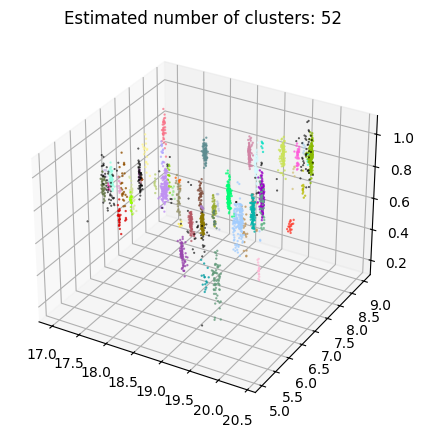

In [90]:
clusterer = HDBSCAN(min_cluster_size=5, min_samples=4)
desmin = sq1["desmin"]
clusterer.fit(sq1["desmin"])
fig, ax = plt.subplots(1, 1, figsize=(7, 5), subplot_kw={"projection": "3d"})
ax = clustered_scatterplot(ax, desmin, clusterer.labels_)

In [91]:
def find_cluster_convexhulls(
    points: Float[np.ndarray, "N 3"], **clusterer_kwargs
) -> list[scspatial.ConvexHull]:
    clusterer = HDBSCAN(**clusterer_kwargs)
    clusterer.fit(points)
    unique_labels = set(clusterer.labels_)
    hulls = []
    for lb in tqdm(unique_labels):
        if lb == -1:
            continue
        try:
            cluster_points = points[clusterer.labels_ == lb]
            hulls.append(scspatial.ConvexHull(cluster_points))
        except scspatial.QhullError:
            continue
    return hulls


def convexhull_center_of_mass(hull: scspatial.ConvexHull) -> Float[np.ndarray, " 3"]:
    return np.mean(hull.points[hull.vertices, :], axis=0)


hulls = find_cluster_convexhulls(desmin, min_cluster_size=5, min_samples=1)
cluster_vol_desmin = np.asarray([h.volume for h in hulls])
cluster_cm_desmin = np.stack([convexhull_center_of_mass(h) for h in hulls], axis=0)


/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
100%|██████████| 78/78 [00:00<00:00, 8650.11it/s]


In [ ]:
cluster_cm_sarco_dists = nearest_Z_line_distances(cluster_cm_desmin, sarco_pos)

(array([[0., 0., 2., 0., 1., 3., 0., 3., 2., 0.],
        [0., 1., 3., 1., 3., 1., 0., 4., 1., 0.],
        [0., 0., 1., 0., 1., 4., 2., 2., 3., 0.],
        [2., 5., 3., 5., 4., 2., 0., 2., 0., 1.],
        [0., 0., 1., 0., 1., 2., 0., 3., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]),
 array([0.0040298 , 0.06495173, 0.12587365, 0.18679557, 0.2477175 ,
        0.30863942, 0.36956135, 0.43048327, 0.4914052 , 0.55232712,
        0.61324905]),
 array([-7.17657262, -6.67212435, -6.16767608, -5.66322781, -5.15877954,
        -4.65433128, -4.14988301, -3.64543474, -3.14098647, -2.63653821,
        -2.13208994]),
 <matplotlib.collections.QuadMesh at 0x14b8a79de360>)

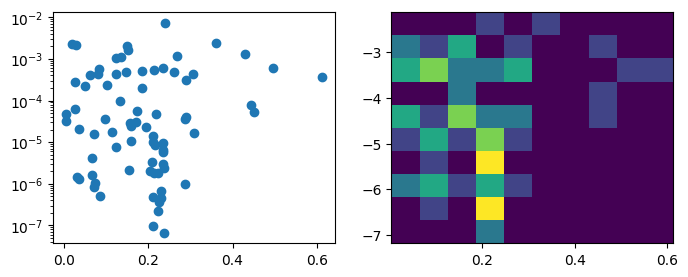

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].scatter(cluster_cm_sarco_dists, cluster_vol_desmin)
axes[0].set_yscale("log")

axes[1].hist2d(cluster_cm_sarco_dists, np.log10(cluster_vol_desmin), bins=10)

In [ ]:
sarcomere_distances = []
for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points_final.items()}
    transform_fn_sq, _ = align_patch(
        sq1,
        tilt_sweep_values=np.arange(-5, 5, 0.001),
        rotation_sweep_values=np.arange(-4, 4, 0.1),
        min_cluster_size=500,
        min_samples=10,
    )
    sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}
    sarco_pos, _ = detect_Z_lines(sq1_final["actinin"])
    sq_sarco_dists = {
        k: nearest_Z_line_distances(v, sarco_pos) for k, v in sq1_final.items()
    }
    sarcomere_distances.append(sq_sarco_dists)

100%|██████████| 10000/10000 [00:02<00:00, 3457.86it/s]
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/Projects/ProteinStructureReconstruction.jl/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

In [ ]:
dist_bins = np.linspace(0, 1.0, 200)
hist_counts = {
    k: [
        np.histogram(dist_dict[k], bins=dist_bins, density=True)[0]
        for dist_dict in sarcomere_distances
    ]
    for k in ("desmin", "actinin")
}
hist_counts["desmin"]

[array([1.57677596, 1.90300546, 2.01174863, 2.66420765, 2.66420765,
        1.68551913, 1.7942623 , 1.46803279, 1.7942623 , 2.17486339,
        1.73989071, 2.77295082, 2.88169399, 2.99043716, 2.66420765,
        3.09918033, 2.60983607, 2.77295082, 2.77295082, 2.66420765,
        2.44672131, 4.45846995, 3.26229508, 2.22923497, 2.17486339,
        2.17486339, 2.22923497, 1.46803279, 1.95737705, 1.57677596,
        0.81557377, 0.65245902, 0.92431694, 0.48934426, 0.92431694,
        0.7068306 , 0.65245902, 1.35928962, 1.35928962, 2.44672131,
        3.15355191, 2.55546448, 2.88169399, 3.26229508, 3.42540984,
        2.77295082, 3.15355191, 3.96912568, 2.99043716, 2.01174863,
        1.7942623 , 1.4136612 , 1.35928962, 2.01174863, 3.2079235 ,
        2.44672131, 3.64289617, 4.83907104, 3.86038251, 4.02349727,
        3.47978142, 2.60983607, 2.17486339, 2.33797814, 1.95737705,
        2.1204918 , 2.1204918 , 1.90300546, 1.84863388, 2.1204918 ,
        2.17486339, 2.28360656, 2.28360656, 1.73

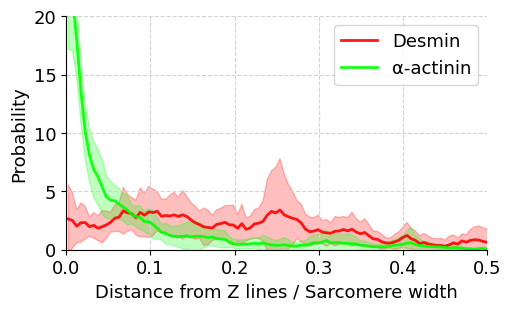

In [ ]:
plt.rc("font", size=13)
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
for protein, distances in hist_counts.items():
    ax = line_and_bandplot(
        ax,
        (dist_bins[:-1] + dist_bins[1:]) / 2,
        np.mean(distances, axis=0),
        np.std(distances, axis=0),
        color=COLOR_DICT[protein],
        label=LABEL_DICT[protein],
        linewidth=2.0,
        alpha=0.9,
        alpha_band=0.25,
    )
ax.set_xlim((0, 0.5))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="lightgray")
ax.set_xlabel("Distance from Z lines / Sarcomere width")
ax.set_ylabel("Probability")
ax.legend(loc="upper right")
ax.set_ylim((0, 20))
fig.savefig("../figures/fig_2/2d.svg", dpi=500)

In [ ]:
desmin_distances = []
gf_desmin = []
for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points_final.items()}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        transform_fn_sq, _ = align_patch(
            sq1,
            tilt_sweep_values=np.arange(-5, 5, 0.001),
            rotation_sweep_values=np.arange(-4, 4, 0.1),
            min_cluster_size=500,
            min_samples=10,
        )
    sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}
    sarco_pos, _ = detect_Z_lines(sq1_final["actinin"])
    desmin_distances.append(nearest_Z_line_distances(sq1_final["desmin"], sarco_pos))
    gf_desmin.append(getis_franklin_L(sq1_final["desmin"], 0.1385, [4.0, 4.0, 1.0]))

100%|██████████| 16/16 [04:49<00:00, 18.07s/it]


In [28]:
hists = [
    np.histogram2d(dist_i, gf_i, (np.linspace(0, 0.5, 20), np.linspace(0, 1.0, 20)))[0]
    for dist_i, gf_i in zip(desmin_distances, gf_desmin)
]


In [29]:
np.array(hists).shape

(16, 19, 19)

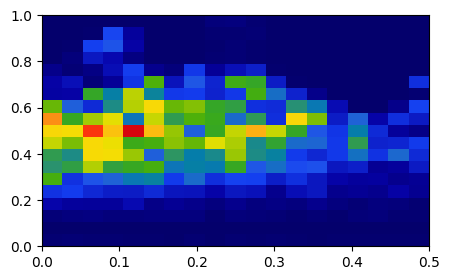

In [ ]:
import colorcet as cc


fig, ax = plt.subplots(1, 1, figsize=(5, 3))
mesh = ax.pcolormesh(
    np.linspace(0, 0.5, 20),
    np.linspace(0, 1.0, 20),
    np.mean(hists, axis=0).T,
    cmap=cc.cm.rainbow4,
    antialiased=True,
)

In [ ]:
cluster_distances = []
cluster_volumes = []
for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points_final.items()}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        transform_fn_sq, _ = align_patch(
            sq1,
            tilt_sweep_values=np.arange(-5, 5, 0.001),
            rotation_sweep_values=np.arange(-4, 4, 0.1),
            min_cluster_size=500,
            min_samples=10,
        )
    sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}
    sarco_pos, _ = detect_Z_lines(sq1_final["actinin"])
    hulls = find_cluster_convexhulls(
        sq1_final["desmin"], min_cluster_size=5, min_samples=4
    )
    cluster_volumes.append(np.asarray([h.volume for h in hulls]))
    cluster_cm_desmin = np.stack([convexhull_center_of_mass(h) for h in hulls], axis=0)
    cluster_distances.append(nearest_Z_line_distances(cluster_cm_desmin, sarco_pos))

100%|██████████| 80/80 [00:12<00:00,  6.55it/s]
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
100%|██████████| 80/80 [00:07<00:00, 11.35it/s]
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will 

In [22]:
len(cluster_distances)

16

(0.0, 0.5)

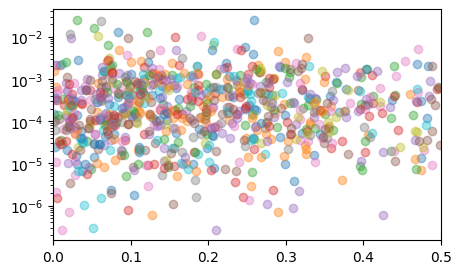

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for cd, cv in zip(cluster_distances, cluster_volumes):
    ax.scatter(cd, cv, alpha=0.4)
ax.set_yscale("log")
ax.set_xlim((0, 0.5))

In [80]:
counts_2d = []
bins = (np.linspace(0, 1.0, 40), np.linspace(-7, -1, 40))
for cluster_dist, cluster_vol in zip(cluster_distances, cluster_volumes):
    counts_2d.append(
        np.histogram2d(cluster_dist, np.log10(cluster_vol), bins=bins, density=True)[0]
    )

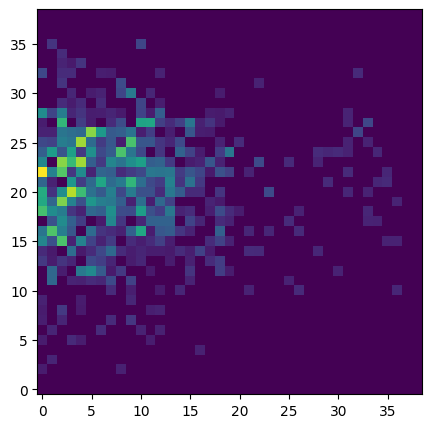

In [81]:
counts_2d_mean = np.mean(counts_2d, axis=0)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(counts_2d_mean.T, origin="lower")

In [ ]:
from desmin_reconstruction.colocalization.costes.analysis import deming_regression


slopes = []
for cd, cv in zip(cluster_distances, cluster_volumes):
    valid_idx = cd <= 0.5
    slopes.append(deming_regression(cd[valid_idx], np.log10(cv[valid_idx]))[0])

In [97]:
slopes

[Array(39.128166, dtype=float32),
 Array(0.01498032, dtype=float32),
 Array(0.03093529, dtype=float32),
 Array(347.05908, dtype=float32),
 Array(330.8937, dtype=float32),
 Array(26.50346, dtype=float32),
 Array(41.344505, dtype=float32),
 Array(0.02232742, dtype=float32),
 Array(0.05675602, dtype=float32),
 Array(30.088722, dtype=float32),
 Array(15.149424, dtype=float32),
 Array(0.03046036, dtype=float32),
 Array(0.00777435, dtype=float32),
 Array(50.92111, dtype=float32),
 Array(0.0234623, dtype=float32),
 Array(0.01494598, dtype=float32)]